In [30]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GAT

from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np


In [ ]:
pip install stellargraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 435 kB 5.1 MB/s 


# loading the CORA dataset

In [8]:
dataset = datasets.Cora()
display(HTML(dataset.description))
G, node_subjects = dataset.load()
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1433
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


the goal is to predict the category of a paper (node_subject)

# splitting the data
150 nodes for training
500 nodes for validation
2058 for testing

In [9]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects, train_size=140, test_size=None, stratify=node_subjects)

val_subjects, test_subjects = model_selection.train_test_split(test_subjects, train_size=500, test_size=None, stratify=test_subjects)

# one-hot embedding for categorical target

In [10]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

# Creating the GAT model

feeding node features and graph adjacency matrix into model

In [11]:
generator = FullBatchNodeGenerator(G, method="gat")
train_gen = generator.flow(train_subjects.index, train_targets)
val_gen = generator.flow(val_subjects.index, val_targets)
test_gen = generator.flow(test_subjects.index, test_targets)

we create a two layer GAT (first layer = 8 dim node features, second layer = 7 class outpout for classifying 7 categories)
8 attention heads (a concatination of gat layesr with separate Ws) in all but the last layer 

In [12]:
gat = GAT(
    layer_sizes=[8, train_targets.shape[1]],
    activations=["relu", "softmax"],
    attn_heads=8,
    generator=generator,
    in_dropout=0.5,
    attn_dropout=0.5,
    normalize=None,
)

Specifying gat input and output

In [13]:
x_inp, predictions = gat.in_out_tensors()

# training the model

creating the model with x_inp and predictions from final dense layer

In [17]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


early stopping

In [15]:
if not os.path.isdir("logs"):
    os.makedirs("logs")
es_callback = EarlyStopping(
    monitor="val_acc", patience=20
)  # patience is the number of epochs to wait before early stopping in case of no further improvement
mc_callback = ModelCheckpoint(
    "logs/best_model.h5", monitor="val_acc", save_best_only=True, save_weights_only=True
)

training

In [18]:
history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    verbose=2,
    shuffle=False,  # this should be False, since shuffling data means shuffling the whole graph
    callbacks=[es_callback, mc_callback],
)

Epoch 1/50
1/1 - 4s - loss: 2.0250 - acc: 0.0643 - val_loss: 1.9033 - val_acc: 0.3240 - 4s/epoch - 4s/step
Epoch 2/50
1/1 - 0s - loss: 1.8845 - acc: 0.2143 - val_loss: 1.8515 - val_acc: 0.3700 - 333ms/epoch - 333ms/step
Epoch 3/50
1/1 - 0s - loss: 1.8044 - acc: 0.3857 - val_loss: 1.7978 - val_acc: 0.3660 - 313ms/epoch - 313ms/step
Epoch 4/50
1/1 - 0s - loss: 1.7662 - acc: 0.4071 - val_loss: 1.7432 - val_acc: 0.3740 - 340ms/epoch - 340ms/step
Epoch 5/50
1/1 - 0s - loss: 1.7012 - acc: 0.4500 - val_loss: 1.6867 - val_acc: 0.3860 - 337ms/epoch - 337ms/step
Epoch 6/50
1/1 - 0s - loss: 1.6201 - acc: 0.4286 - val_loss: 1.6303 - val_acc: 0.4160 - 343ms/epoch - 343ms/step
Epoch 7/50
1/1 - 0s - loss: 1.5878 - acc: 0.4500 - val_loss: 1.5734 - val_acc: 0.4320 - 338ms/epoch - 338ms/step
Epoch 8/50
1/1 - 0s - loss: 1.4786 - acc: 0.5000 - val_loss: 1.5154 - val_acc: 0.4660 - 352ms/epoch - 352ms/step
Epoch 9/50
1/1 - 0s - loss: 1.4137 - acc: 0.5286 - val_loss: 1.4577 - val_acc: 0.4900 - 332ms/epoch - 

plotting history

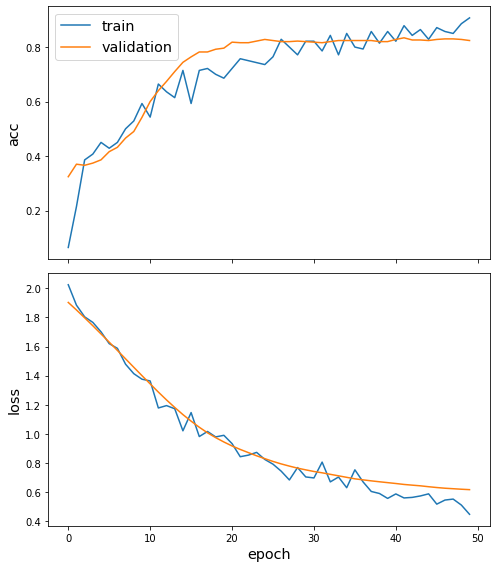

In [19]:
sg.utils.plot_history(history)

weights of the best model found during training

In [22]:
model.load_weights("logs/best_model.h5")

evaluate best test set

In [23]:
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 91ms/step - loss: 0.6774 - acc: 0.8138

Test Set Metrics:
	loss: 0.6774
	acc: 0.8138


# predictions

prediction for all nodes

In [25]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)
#inverse transform for categorical data
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

some examples

In [26]:
df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
df.head(20)

Predicted                    True
31336           Neural_Networks         Neural_Networks
1061127           Rule_Learning           Rule_Learning
1106406  Reinforcement_Learning  Reinforcement_Learning
13195    Reinforcement_Learning  Reinforcement_Learning
37879     Probabilistic_Methods   Probabilistic_Methods
1126012   Probabilistic_Methods   Probabilistic_Methods
1107140  Reinforcement_Learning                  Theory
1102850         Neural_Networks         Neural_Networks
31349           Neural_Networks         Neural_Networks
1106418                  Theory                  Theory
1123188         Neural_Networks         Neural_Networks
1128990      Genetic_Algorithms      Genetic_Algorithms
109323    Probabilistic_Methods   Probabilistic_Methods
217139               Case_Based              Case_Based
31353           Neural_Networks         Neural_Networks
32083           Neural_Networks         Neural_Networks
1126029  Reinforcement_Learning  Reinforcement_Learning
1118017         Neural_Networks         Neural_Networks
49482           Neural_Networks         Neural_Networks
753265          Neural_Networks         Neural_Networks

# Node embeddings

evaluating node embeddings (dim reduction with pca) by visualizing them with their true labels as colors.
since we want to evaluate the embeddings we need the output of the first layer

In [29]:
emb_layer = next(l for l in model.layers if l.name.startswith("graph_attention"))
print("Embedding layer: {}, output shape {}".format(emb_layer.name, emb_layer.output_shape))
embedding_model = Model(inputs=x_inp, outputs=emb_layer.output)
#calculate embeddings 
emb = embedding_model.predict(all_gen)

Embedding layer: graph_attention_sparse, output shape (1, 2708, 64)


squeeze to remove the batch dimension (1) from shape

In [31]:
X = emb.squeeze()
y = np.argmax(target_encoding.transform(node_subjects), axis=1)

reducing the dimension of embeddings for visualization

In [32]:
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=list(G.nodes()))
    emb_transformed["label"] = y
else:
    emb_transformed = pd.DataFrame(X, index=list(G.nodes()))
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
    emb_transformed["label"] = y

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


plotting

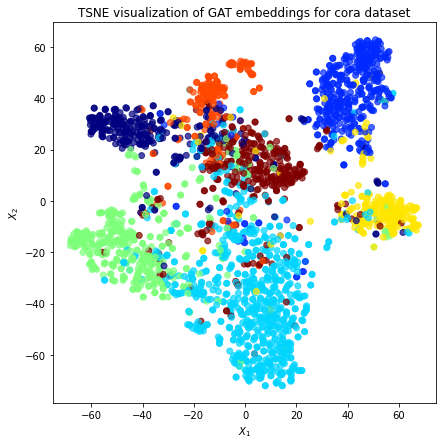

In [33]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["label"].astype("category"),
    cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GAT embeddings for cora dataset".format(transform.__name__)
)
plt.show()